# Image segmentation with a U-Net-like architecture

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/03/20<br>
**Last modified:** 2020/04/20<br>
**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

## Prepare paths of input images and target segmentation masks

In [7]:
import os

input_folder = "stream_dataset"

input_dir = os.path.join(input_folder, "images/")
target_dir = os.path.join(input_folder, "labels")
img_size = (1024, 1024)
num_classes = 2
batch_size = 1

# inputs end with ".JPG"
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".JPG")
    ]
)
# labels end with "_label.png"
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith("_label.png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))
print("Number of labels:", len(target_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 1222
Number of labels: 1222
stream_dataset/images/S-1_D021120_021820_47_I11_NE_L4.JPG | stream_dataset/labels/S-1_D021120_021820_47_I11_NE_L4_label.png
stream_dataset/images/S-1_D021120_021820_47_I18_NE_L4.JPG | stream_dataset/labels/S-1_D021120_021820_47_I18_NE_L4_label.png
stream_dataset/images/S-1_D021120_021820_47_I48_NE_L4.JPG | stream_dataset/labels/S-1_D021120_021820_47_I48_NE_L4_label.png
stream_dataset/images/S-1_D021120_021820_47_I49_NE_L4.JPG | stream_dataset/labels/S-1_D021120_021820_47_I49_NE_L4_label.png
stream_dataset/images/S-1_D021120_021820_47_I55_NE_L4.JPG | stream_dataset/labels/S-1_D021120_021820_47_I55_NE_L4_label.png
stream_dataset/images/S-1_D021120_021820_47_I65_NE_L4.JPG | stream_dataset/labels/S-1_D021120_021820_47_I65_NE_L4_label.png
stream_dataset/images/S-1_D061720_072220_49_I107_NE_L3.JPG | stream_dataset/labels/S-1_D061720_072220_49_I107_NE_L3_label.png
stream_dataset/images/S-1_D061720_072220_49_I311_NE_L2.JPG | stream_dataset/labels/

## What does one input image and corresponding segmentation mask look like?

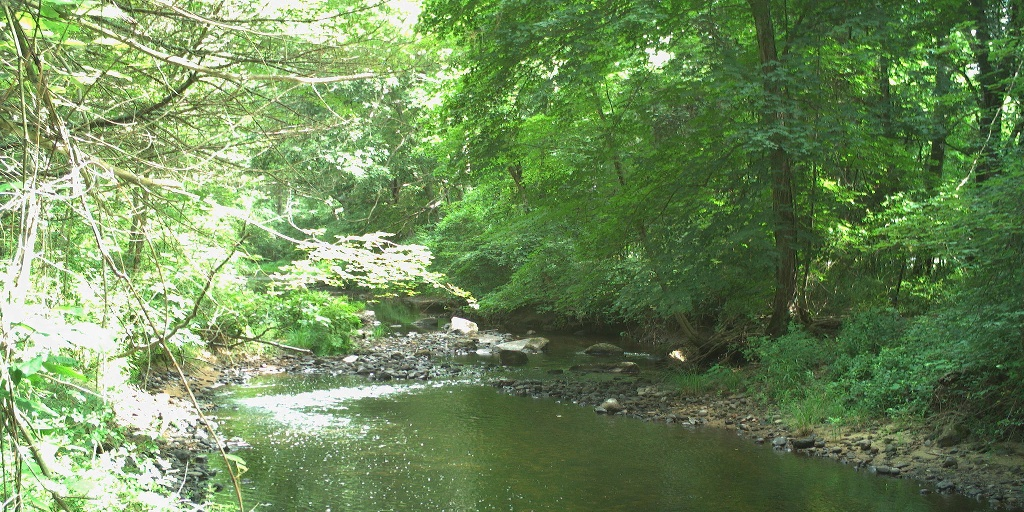

stream_dataset/images/S-1_D062420_081920_60_I232_NE_L4.JPG
stream_dataset/labels/S-1_D062420_081920_60_I232_NE_L4_label.png


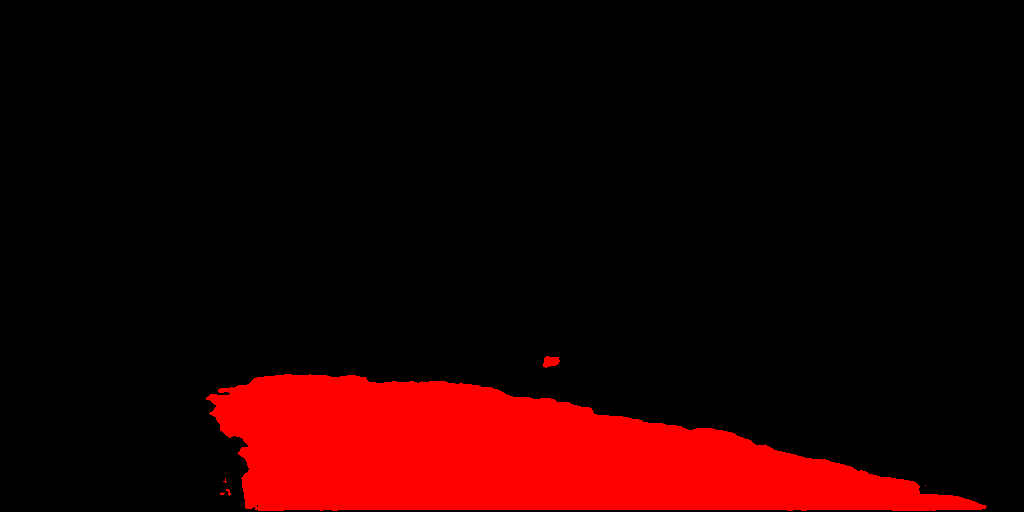

In [8]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[20]))
print(input_img_paths[20])

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[20]))
print(target_img_paths[20])
display(img)

## Prepare dataset to load & vectorize batches of data

In [9]:
import keras
import numpy as np
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
import tensorflow as tf

def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def pad_to_square(image, target_size):
        """Pad image to square with zeros, maintaining aspect ratio."""
        # Get current dimensions
        current_height = tf.shape(image)[0]
        current_width = tf.shape(image)[1]
        
        # Calculate padding needed
        max_dim = tf.maximum(current_height, current_width)
        target_dim = target_size[0]  # Assuming square target
        
        # Calculate padding for each side
        pad_height = (target_dim - current_height) // 2
        pad_width = (target_dim - current_width) // 2
        
        # Create padding tensor [[top, bottom], [left, right], [channels]]
        if len(image.shape) == 3:
            paddings = [[pad_height, target_dim - current_height - pad_height],
                       [pad_width, target_dim - current_width - pad_width],
                       [0, 0]]
        else:
            paddings = [[pad_height, target_dim - current_height - pad_height],
                       [pad_width, target_dim - current_width - pad_width]]
        
        return tf.pad(image, paddings, mode='CONSTANT', constant_values=0)

    def load_img_masks(input_img_path, target_img_path):
        # Load input image
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.convert_image_dtype(input_img, "float32")
        
        # Load target image
        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.convert_image_dtype(target_img, "uint8")
        
        # First resize to maintain aspect ratio, then pad to square
        # Option 1: Resize to fit within square, then pad
        input_img = tf_image.resize_with_pad(input_img, img_size[0], img_size[0])
        target_img = tf_image.resize_with_pad(target_img, img_size[0], img_size[0], method="nearest")
        
        # Process target image
        target_img = tf.where(target_img == 0, 0, 1)
        target_img = tf.cast(target_img, tf.uint8)

        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)


## Prepare U-Net Xception-style model

In [10]:
from keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 512, 512,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        128 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 512, 512,  │          0 │ activation_15[0]… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_6  │ (None, 512, 512,  │      2,400 │ activation_16[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_7  │ (None, 512, 512,  │      4,736 │ activation_17[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 256, 256,  │      2,112 │ activation_15[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 256, 256,  │          0 │ max_pooling2d_3[… │
│                     │ 64)               │            │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 256, 256,  │          0 │ add_7[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_8  │ (None, 256, 256,  │      8,896 │ activation_18[0]… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 256, 256,  │          0 │ batch_normalizat

 Total params: 2,058,690 (7.85 MB)

 Trainable params: 2,054,914 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

## Set aside a validation split

In [11]:
import random

# Split our img paths into a training and a validation set
val_samples = 200
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=150,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

## Train the model

In [12]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
def iou_metric(y_true, y_pred):
    """Calculate IoU metric for binary segmentation"""
    # Convert predictions to binary (argmax for multi-class)
    y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    
    # Flatten tensors
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    
    # Avoid division by zero
    iou = tf.cond(tf.equal(union, 0), 
                  lambda: 1.0, 
                  lambda: intersection / union)
    
    return iou

model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss= "sparse_categorical_crossentropy", metrics=["accuracy", iou_metric]
)

callbacks = [
    keras.callbacks.ModelCheckpoint("stream_segmentation.keras", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 30
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/30


I0000 00:00:1758818545.248687  164411 service.cc:152] XLA service 0x769b900031b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758818545.248709  164411 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 4000 Ada Generation, Compute Capability 8.9
2025-09-25 12:42:25.433657: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-25 12:42:25.898140: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1758818546.441802  164411 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-09-25 12:42:26.966378: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please inves

150/150 - 37s - 249ms/step - accuracy: 0.8355 - iou_metric: 0.3682 - loss: 0.6286 - val_accuracy: 0.8237 - val_iou_metric: 0.0000e+00 - val_loss: 0.8935
Epoch 2/30
150/150 - 13s - 86ms/step - accuracy: 0.8736 - iou_metric: 0.4434 - loss: 0.3295 - val_accuracy: 0.8237 - val_iou_metric: 0.0000e+00 - val_loss: 0.9859
Epoch 3/30
150/150 - 13s - 87ms/step - accuracy: 0.8858 - iou_metric: 0.4780 - loss: 0.2790 - val_accuracy: 0.8236 - val_iou_metric: 1.1923e-04 - val_loss: 0.5667
Epoch 4/30
150/150 - 13s - 87ms/step - accuracy: 0.8986 - iou_metric: 0.5127 - loss: 0.2397 - val_accuracy: 0.8353 - val_iou_metric: 0.4011 - val_loss: 0.3007
Epoch 5/30
150/150 - 13s - 88ms/step - accuracy: 0.9098 - iou_metric: 0.5434 - loss: 0.2121 - val_accuracy: 0.8845 - val_iou_metric: 0.4790 - val_loss: 0.2536
Epoch 6/30
150/150 - 13s - 86ms/step - accuracy: 0.9183 - iou_metric: 0.5683 - loss: 0.1921 - val_accuracy: 0.8942 - val_iou_metric: 0.4779 - val_loss: 0.2552
Epoch 7/30
150/150 - 13s - 88ms/step - accur

## Visualize predictions

200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


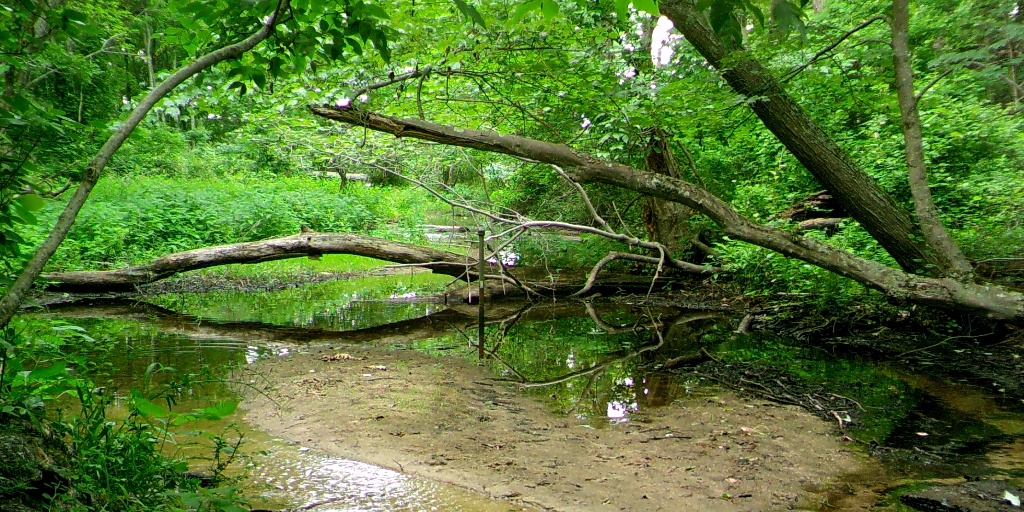

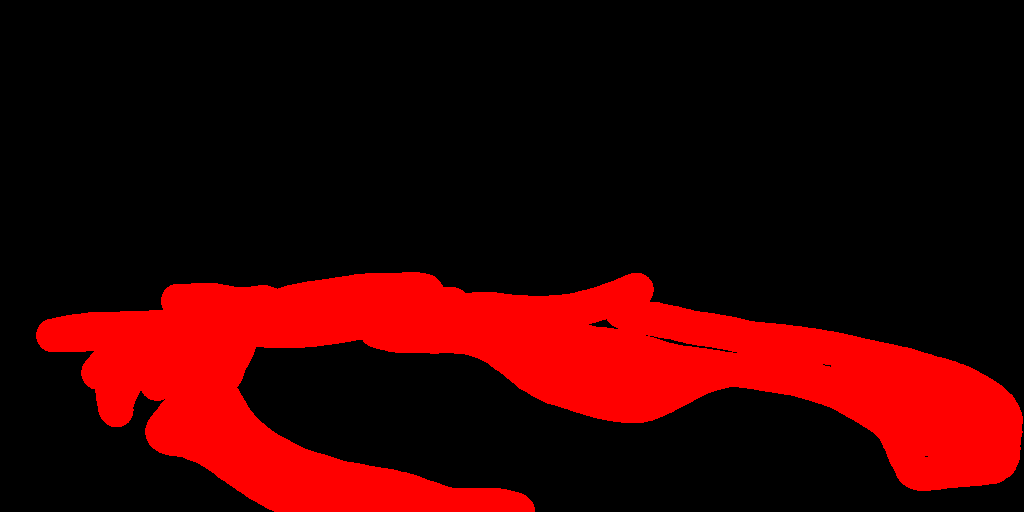

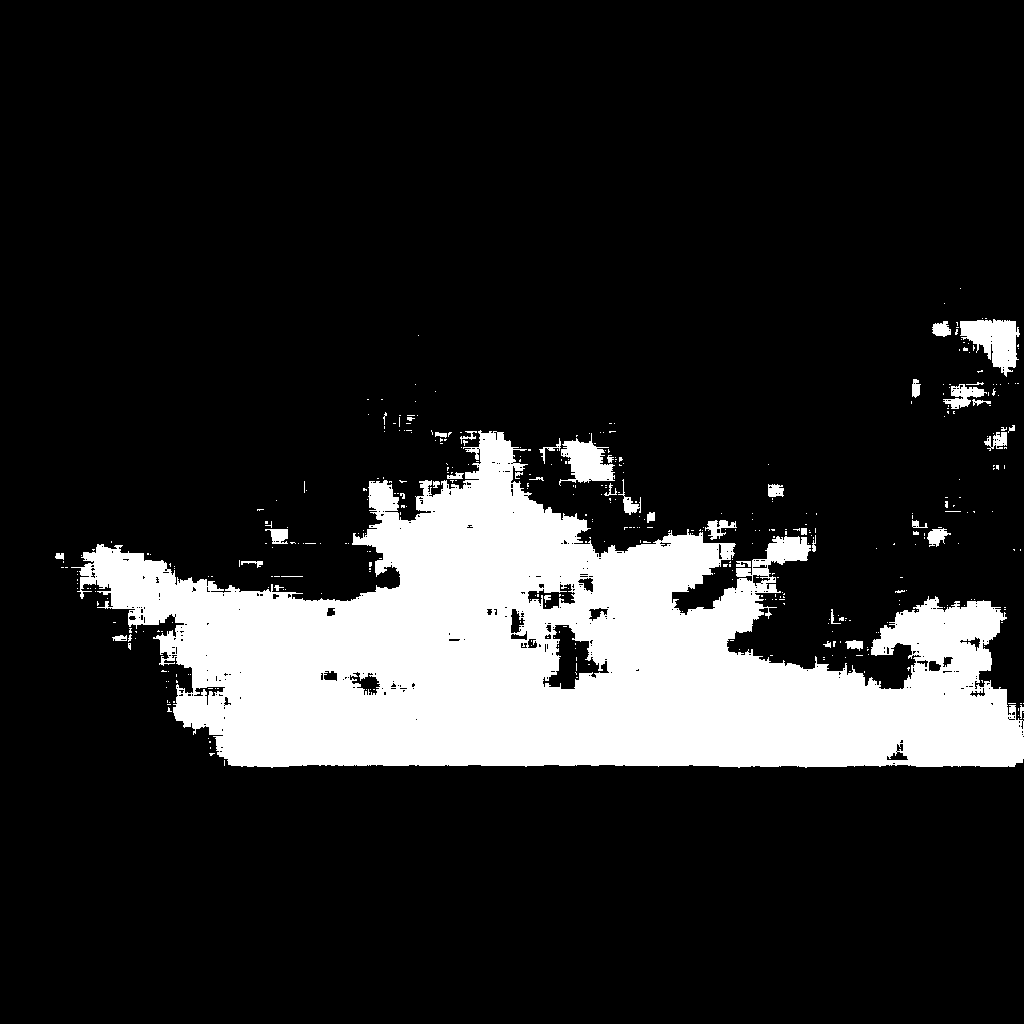

In [13]:
# Generate predictions for all images in the validation set

val_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)
val_preds = model.predict(val_dataset)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 112


# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.